installe les packages nécessaires et importe les bibliothèques.

In [12]:
pip install pyspark matplotlib seaborn pandas

Note: you may need to restart the kernel to use updated packages.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

Création de la Session Spark et Chargement des Données

In [15]:
# %%
# Création de la session Spark
spark = SparkSession.builder.appName("HiggsBosonEDA").getOrCreate()

# %%
# Chargement du dataset (adapté pour un fichier CSV ou CSV.gz)
train_path = "HIGGS-Train.csv"  # Remplacer par "HIGGS-Train.csv.gz" si le fichier est compressé
df = spark.read.csv(train_path, header=False, inferSchema=True)

# %%
# Renommage des colonnes : 
# 1ère colonne = "label", puis "feature_1" jusqu'à "feature_28"
col_names = ["label"] + [f"feature_{i}" for i in range(1, 29)]
df = df.toDF(*col_names)

# Vérification de quelques lignes du dataset
df.show(5)


+-----+------------------+-------------------+-------------------+------------------+-------------------+------------------+--------------------+-------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+--------------------+-------------------+-----------------+-------------------+--------------------+--------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|label|         feature_1|          feature_2|          feature_3|         feature_4|          feature_5|         feature_6|           feature_7|          feature_8|         feature_9|        feature_10|         feature_11|         feature_12|        feature_13|        feature_14|          feature_15|         feature_16|       feature_17|         feature_18|          feature_19|          feature_20|       feature_21|        feature_22|       

Statistiques Descriptives Univariées et Bivariées
Nous affichons les statistiques globales et les moyennes par classe (label) pour comprendre les distributions

In [16]:
# %%
# Statistiques descriptives globales sur tout le dataset
print("Statistiques descriptives globales :")
df.describe().show()

# %%
# Statistiques descriptives par label (comparaison entre classes)
print("Statistiques descriptives par label :")
df.groupBy("label").mean().show()


Statistiques descriptives globales :


+-------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------------+------------------+-------------------+-------------------+-------------------+-------------------+------------------+-------------------+------------------+
|summary|             label|         feature_1|           feature_2|           feature_3|           feature_4|           feature_5|          feature_6|           feature_7|           feature_8|         feature_9|         feature_10|          feature_11|          feature_12|        feature_13|         feature_14|          feature_15|          feature_16|        feature_17|         feature_18|          fe

+-----+----------+-----------------+--------------------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|label|avg(label)|   avg(feature_1)|      avg(feature_2)|      avg(feature_3)|    avg(feature_4)|      avg(feature_5)|    avg(feature_6)|      avg(feature_7)|      avg(feature_8)|    avg(feature_9)|   avg(feature_10)|     avg(feature_11)|     avg(feature_12)|   avg(feature_13)|   avg(feature_14)|     avg(feature_15)|     avg(feature_16)|   avg(feature_17)|   avg(feature_18)|     avg(feature_19)|     avg(feature_20)|   avg(fea

Conversion en DataFrame Pandas pour Visualisation
Pour tracer les graphiques, nous convertissons un échantillon du dataframe Spark en Pandas.

In [17]:
# %%
# Conversion en DataFrame Pandas
# Pour des datasets volumineux, on effectue un échantillonnage (ici 10% des données)
pdf = df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()


Matrices de Corrélation
Nous traçons deux matrices de corrélation simples :

Une pour les 21 premières caractéristiques (colonnes 2 à 22)
Une pour l'ensemble des 28 features

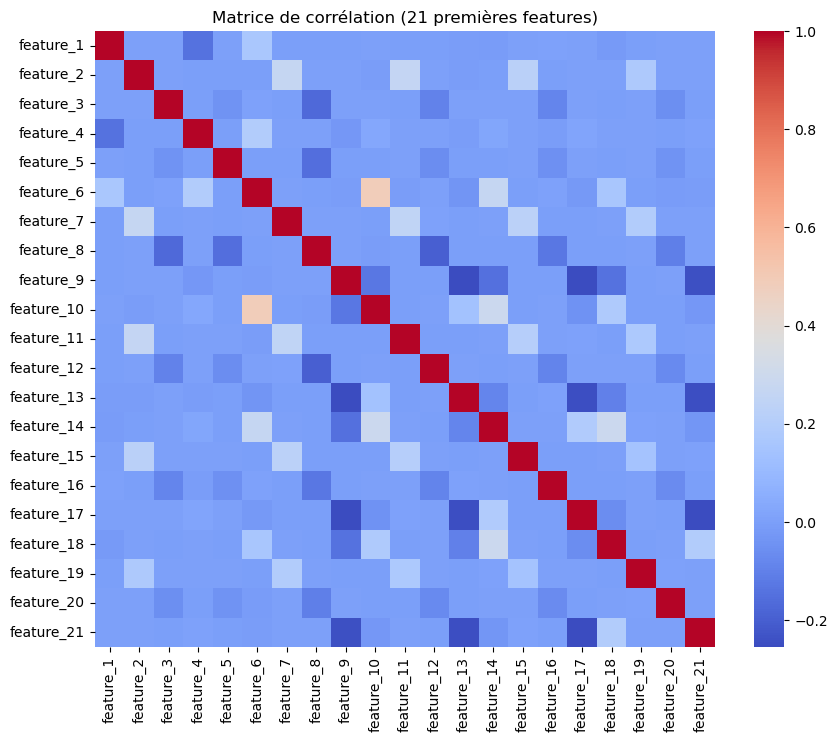

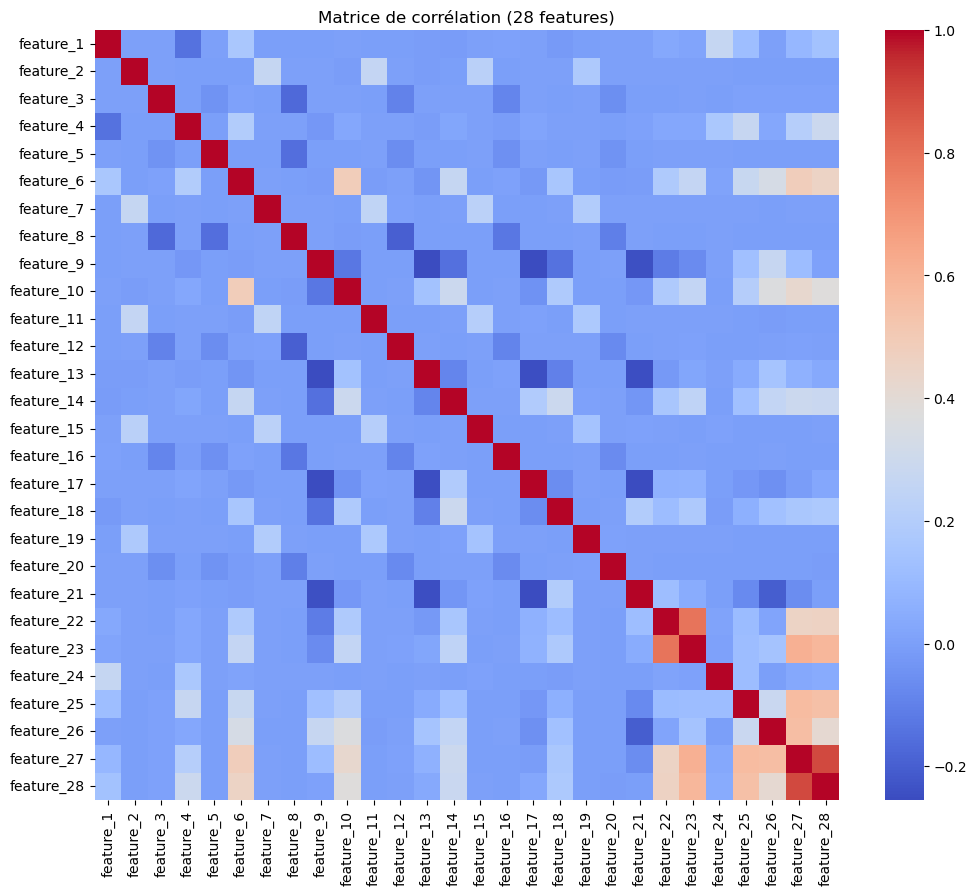

In [18]:
# %%
# Matrice de corrélation sur les 21 premières caractéristiques (feature_1 à feature_21)
features_21 = [f"feature_{i}" for i in range(1, 22)]
corr_matrix_21 = pdf[features_21].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_21, cmap='coolwarm', annot=False)
plt.title("Matrice de corrélation (21 premières features)")
plt.show()

# %%
# Matrice de corrélation sur l'ensemble des 28 features (feature_1 à feature_28)
features_28 = [f"feature_{i}" for i in range(1, 29)]
corr_matrix_28 = pdf[features_28].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_28, cmap='coolwarm', annot=False)
plt.title("Matrice de corrélation (28 features)")
plt.show()


Analyse Bivariée avec Boxplots et Histogrammes
Nous réalisons des analyses bivariées simples pour quelques features, en comparant la distribution en fonction du label.

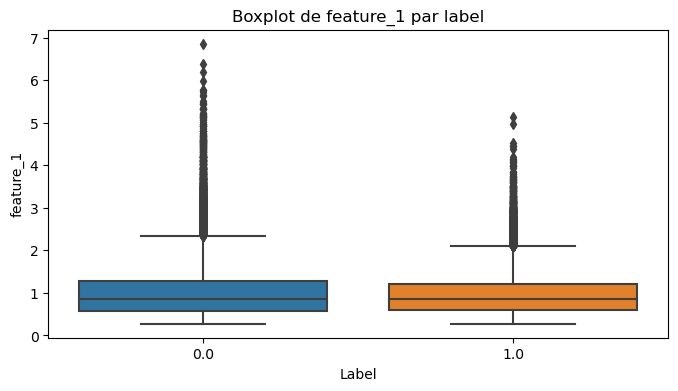

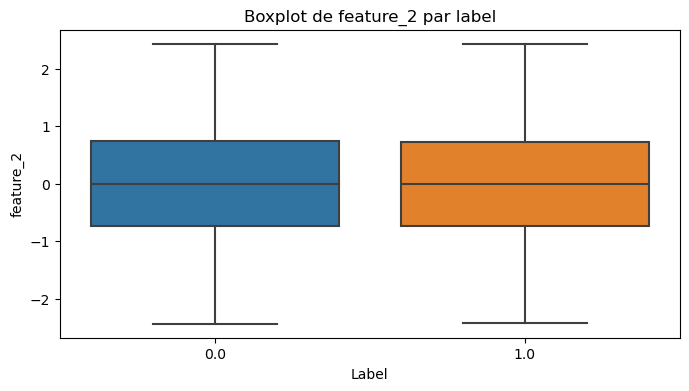

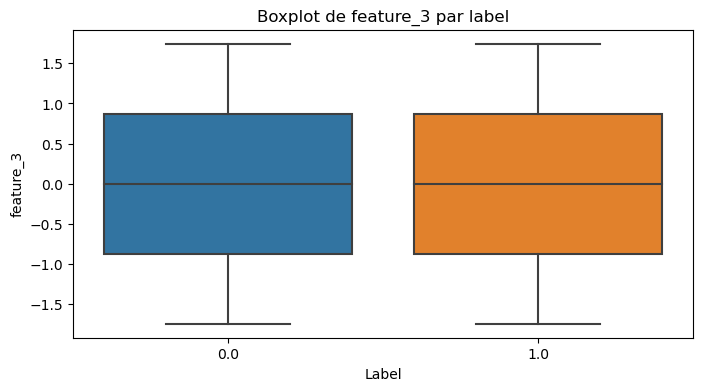

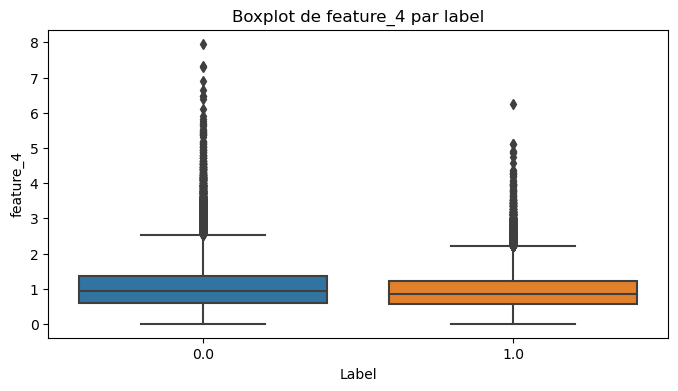

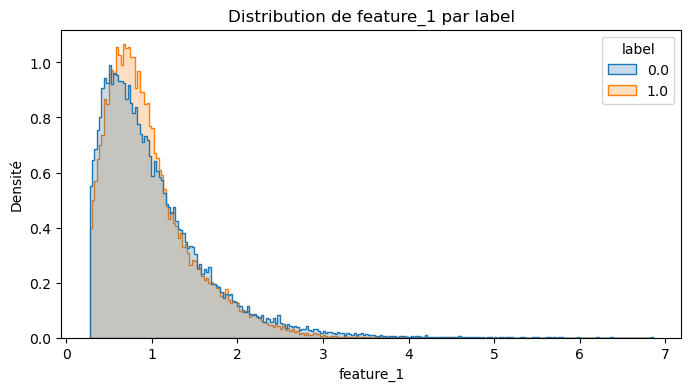

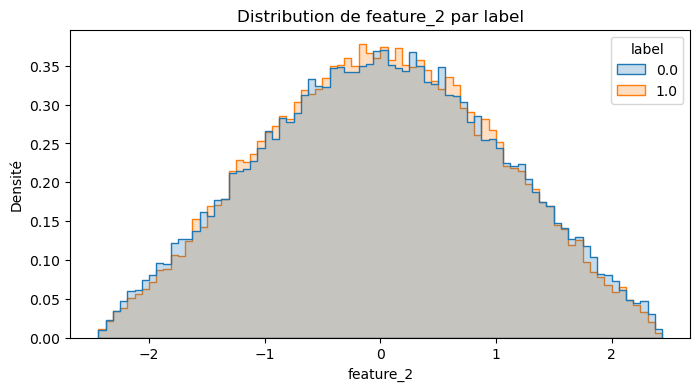

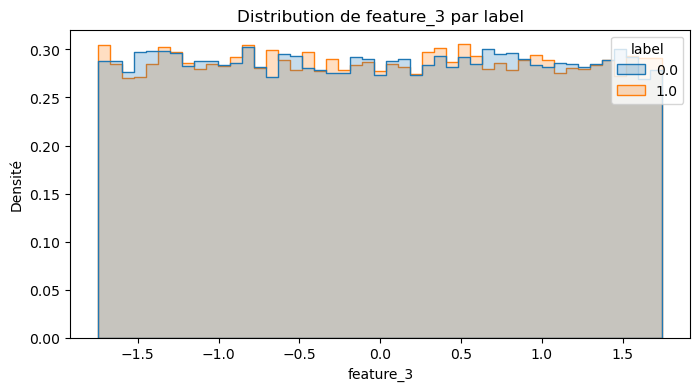

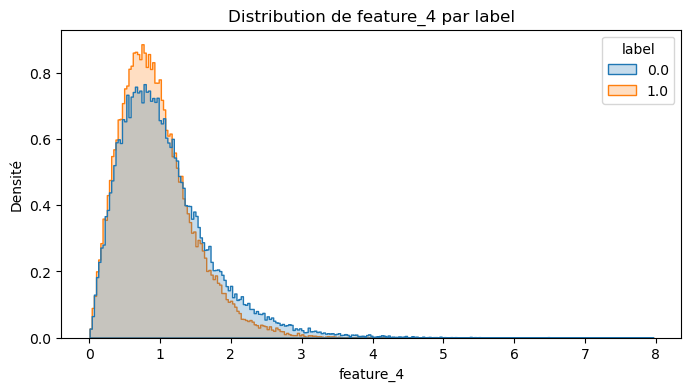

In [19]:
# %%
# Sélection de quelques features pour l'analyse bivariée
features_to_plot = features_21[:4]  # par exemple les 4 premières des 21 caractéristiques

# Boxplots pour visualiser la distribution des valeurs selon le label
for feat in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="label", y=feat, data=pdf)
    plt.title(f"Boxplot de {feat} par label")
    plt.xlabel("Label")
    plt.ylabel(feat)
    plt.show()

# %%
# Histogrammes pour comparer les distributions des features selon le label
for feat in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=pdf, x=feat, hue="label", element="step", stat="density", common_norm=False)
    plt.title(f"Distribution de {feat} par label")
    plt.xlabel(feat)
    plt.ylabel("Densité")
    plt.show()


In [1]:

# %%
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# %%
# Fonction de création de la session Spark avec configuration du nombre de cores
def get_spark_session(app_name, cores):
    return (SparkSession.builder
            .appName(app_name)
            .config("spark.executor.cores", cores)
            .getOrCreate())

In [10]:
# Fonction d'entraînement et d'évaluation du pipeline pour une configuration donnée
def train_pipeline(cpu_cores):
    # Initialiser Spark avec le nombre de CPU cores spécifié
    spark = get_spark_session("HiggsBosonClassification", cpu_cores)
    
    # 1️⃣ Charger les données (les fichiers compressés .gz)
    train_path = "HIGGS-Train.csv"  # ou "HIGGS-Train.csv.gz" si le fichier est compressé
    test_path = "HIGGS-Test.csv"    # ou "HIGGS-Test.csv.gz" si le fichier est compressé
    
    train_df = spark.read.csv(train_path, header=False, inferSchema=True)
    test_df = spark.read.csv(test_path, header=False, inferSchema=True)
    
    # 2️⃣ Renommer les colonnes
    # On nomme toutes les 29 colonnes : la première est le label et les 28 suivantes sont des features.
    col_names = ["label"] + [f"feature_{i}" for i in range(1, 29)]
    train_df = train_df.toDF(*col_names)
    test_df = test_df.toDF(*col_names)
    
    # 3️⃣ Assembler les caractéristiques en un seul vecteur
    # On utilise uniquement les 21 premières features (colonnes 2 à 22) pour la modélisation.
    feature_cols = [f"feature_{i}" for i in range(1, 22)]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    
    train_df = assembler.transform(train_df).select("features", "label")
    test_df = assembler.transform(test_df).select("features", "label")
    
    # 4️⃣ Séparer le jeu d'entraînement (80%) et de validation (20%)
    train_data, val_data = train_df.randomSplit([0.8, 0.2], seed=42)
    
    # 5️⃣ Définir les modèles de classification
    rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=50)
    lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=20)
    gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50)
    
    # 6️⃣ Définir les évaluateurs : ROC et Accuracy
    roc_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
    acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
    
    # 7️⃣ Validation croisée pour Random Forest
    paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [10, 50, 100]).build()
    crossval = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=roc_evaluator, numFolds=3)
    
    # Mesurer le temps d'entraînement du modèle Random Forest (avec validation croisée)
    start_time = time.time()
    rf_model = crossval.fit(train_data)
    elapsed_time = time.time() - start_time
    
    # Entraîner les autres modèles (sans validation croisée pour simplifier la comparaison)
    lr_model = lr.fit(train_data)
    gbt_model = gbt.fit(train_data)
    
    # 8️⃣ Évaluation sur le jeu de validation
    # Random Forest
    rf_predictions = rf_model.transform(val_data)
    rf_auc = roc_evaluator.evaluate(rf_predictions)
    rf_acc = acc_evaluator.evaluate(rf_predictions)
    
    # Logistic Regression
    lr_predictions = lr_model.transform(val_data)
    lr_auc = roc_evaluator.evaluate(lr_predictions)
    lr_acc = acc_evaluator.evaluate(lr_predictions)
    
    # Gradient Boosting
    gbt_predictions = gbt_model.transform(val_data)
    gbt_auc = roc_evaluator.evaluate(gbt_predictions)
    gbt_acc = acc_evaluator.evaluate(gbt_predictions)
    
    print(f"--- Configuration: {cpu_cores} CPU core(s) ---")
    print(f"Temps d'entraînement (RF avec CV) : {elapsed_time:.2f} secondes")
    print(f"AUC (Random Forest)      : {rf_auc:.4f} | Accuracy: {rf_acc:.4f}")
    print(f"AUC (Logistic Regression): {lr_auc:.4f} | Accuracy: {lr_acc:.4f}")
    print(f"AUC (Gradient Boosting)  : {gbt_auc:.4f} | Accuracy: {gbt_acc:.4f}")
    print()
    
    # Sauvegarder le meilleur modèle de Random Forest et l'évaluer sur le jeu de test
    best_rf_model = rf_model.bestModel
    best_rf_model.write().overwrite().save("best_rf_model")
    
    test_predictions = best_rf_model.transform(test_df)
    test_auc = roc_evaluator.evaluate(test_predictions)
    test_acc = acc_evaluator.evaluate(test_predictions)
    print(f"AUC sur le test (Meilleur RF) pour {cpu_cores} core(s): {test_auc:.4f}")
    print(f"Accuracy sur le test (Meilleur RF) pour {cpu_cores} core(s): {test_acc:.4f}")
    print("-------------------------------------------------------\n")
    
    spark.stop()
    
    # Retourne le temps d'entraînement pour la configuration
    return elapsed_time

In [11]:
# %%
# Comparaison des temps d'entraînement en fonction du nombre de CPU cores
cpu_configs = [1, 2, 4, 8]
training_times = {}

for cores in cpu_configs:
    training_times[cores] = train_pipeline(cores)

print("Comparaison globale des temps d'entraînement :")
for cores, t in training_times.items():
    print(f"CPU Cores: {cores}, Temps: {t:.2f} secondes")

25/03/09 13:45:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/03/09 13:49:01 WARN MemoryStore: Not enough space to cache rdd_854_4 in memory! (computed 13.1 MiB so far)
25/03/09 13:49:01 WARN MemoryStore: Not enough space to cache rdd_854_7 in memory! (computed 20.3 MiB so far)
25/03/09 13:49:01 WARN MemoryStore: Not enough space to cache rdd_854_1 in memory! (computed 20.3 MiB so far)
25/03/09 13:49:01 WARN MemoryStore: Not enough space to cache rdd_854_5 in memory! (computed 13.1 MiB so far)
25/03/09 13:49:01 WARN MemoryStore: Not enough space to cache rdd_854_3 in memory! (computed 20.3 MiB so far)
25/03/09 13:49:01 WARN MemoryStore: Not enough space to cache rdd_854_6 in memory! (computed 20.3 MiB so far)
25/03/09 13:49:01 WARN MemoryStore: Not enough space to cache rdd_854_0 in memory! (computed 20.3 MiB so far)
25/03/09 13:49:01 WARN MemoryStore: Not e

--- Configuration: 1 CPU core(s) ---
Temps d'entraînement (RF avec CV) : 212.89 secondes
AUC (Random Forest)      : 0.6373 | Accuracy: 0.5928
AUC (Logistic Regression): 0.5934 | Accuracy: 0.5656
AUC (Gradient Boosting)  : 0.6941 | Accuracy: 0.6395



AUC sur le test (Meilleur RF) pour 1 core(s): 0.6379
Accuracy sur le test (Meilleur RF) pour 1 core(s): 0.5914
-------------------------------------------------------



25/03/09 14:02:48 WARN MemoryStore: Not enough space to cache rdd_834_5 in memory! (computed 13.1 MiB so far)
25/03/09 14:02:48 WARN MemoryStore: Not enough space to cache rdd_834_7 in memory! (computed 13.1 MiB so far)
25/03/09 14:02:48 WARN BlockManager: Persisting block rdd_834_5 to disk instead.
25/03/09 14:02:48 WARN BlockManager: Persisting block rdd_834_7 to disk instead.
25/03/09 14:02:48 WARN MemoryStore: Not enough space to cache rdd_834_2 in memory! (computed 20.3 MiB so far)
25/03/09 14:02:48 WARN BlockManager: Persisting block rdd_834_2 to disk instead.
25/03/09 14:02:48 WARN MemoryStore: Not enough space to cache rdd_834_1 in memory! (computed 20.3 MiB so far)
25/03/09 14:02:48 WARN BlockManager: Persisting block rdd_834_1 to disk instead.
25/03/09 14:02:48 WARN MemoryStore: Not enough space to cache rdd_834_4 in memory! (computed 20.3 MiB so far)
25/03/09 14:02:48 WARN BlockManager: Persisting block rdd_834_4 to disk instead.
25/03/09 14:02:48 WARN MemoryStore: Not enoug

--- Configuration: 2 CPU core(s) ---
Temps d'entraînement (RF avec CV) : 190.42 secondes
AUC (Random Forest)      : 0.6373 | Accuracy: 0.5928
AUC (Logistic Regression): 0.5934 | Accuracy: 0.5656
AUC (Gradient Boosting)  : 0.6941 | Accuracy: 0.6395



AUC sur le test (Meilleur RF) pour 2 core(s): 0.6379
Accuracy sur le test (Meilleur RF) pour 2 core(s): 0.5914
-------------------------------------------------------



25/03/09 14:16:11 WARN MemoryStore: Not enough space to cache rdd_834_2 in memory! (computed 13.1 MiB so far)
25/03/09 14:16:11 WARN BlockManager: Persisting block rdd_834_2 to disk instead.
25/03/09 14:16:11 WARN MemoryStore: Not enough space to cache rdd_834_5 in memory! (computed 13.1 MiB so far)
25/03/09 14:16:11 WARN BlockManager: Persisting block rdd_834_5 to disk instead.
25/03/09 14:16:11 WARN MemoryStore: Not enough space to cache rdd_834_3 in memory! (computed 20.3 MiB so far)
25/03/09 14:16:11 WARN BlockManager: Persisting block rdd_834_3 to disk instead.
25/03/09 14:16:12 WARN MemoryStore: Not enough space to cache rdd_834_0 in memory! (computed 20.3 MiB so far)
25/03/09 14:16:12 WARN MemoryStore: Not enough space to cache rdd_834_6 in memory! (computed 20.3 MiB so far)
25/03/09 14:16:12 WARN MemoryStore: Not enough space to cache rdd_834_1 in memory! (computed 20.3 MiB so far)
25/03/09 14:16:12 WARN BlockManager: Persisting block rdd_834_0 to disk instead.
25/03/09 14:16:1

--- Configuration: 4 CPU core(s) ---
Temps d'entraînement (RF avec CV) : 214.50 secondes
AUC (Random Forest)      : 0.6373 | Accuracy: 0.5928
AUC (Logistic Regression): 0.5933 | Accuracy: 0.5656
AUC (Gradient Boosting)  : 0.6941 | Accuracy: 0.6395



AUC sur le test (Meilleur RF) pour 4 core(s): 0.6379
Accuracy sur le test (Meilleur RF) pour 4 core(s): 0.5914
-------------------------------------------------------



25/03/09 14:30:20 WARN MemoryStore: Not enough space to cache rdd_752_1 in memory! (computed 30.9 MiB so far)
25/03/09 14:30:20 WARN MemoryStore: Not enough space to cache rdd_752_3 in memory! (computed 30.9 MiB so far)
25/03/09 14:30:20 WARN MemoryStore: Not enough space to cache rdd_752_2 in memory! (computed 30.9 MiB so far)
25/03/09 14:30:20 WARN BlockManager: Persisting block rdd_752_2 to disk instead.
25/03/09 14:30:20 WARN BlockManager: Persisting block rdd_752_3 to disk instead.
25/03/09 14:30:20 WARN BlockManager: Persisting block rdd_752_1 to disk instead.
25/03/09 14:31:07 WARN MemoryStore: Not enough space to cache rdd_834_5 in memory! (computed 20.3 MiB so far)
25/03/09 14:31:07 WARN MemoryStore: Not enough space to cache rdd_834_6 in memory! (computed 20.3 MiB so far)
25/03/09 14:31:07 WARN MemoryStore: Not enough space to cache rdd_834_0 in memory! (computed 13.1 MiB so far)
25/03/09 14:31:07 WARN MemoryStore: Not enough space to cache rdd_834_3 in memory! (computed 13.1

--- Configuration: 8 CPU core(s) ---
Temps d'entraînement (RF avec CV) : 218.08 secondes
AUC (Random Forest)      : 0.6373 | Accuracy: 0.5928
AUC (Logistic Regression): 0.5934 | Accuracy: 0.5656
AUC (Gradient Boosting)  : 0.6941 | Accuracy: 0.6395



AUC sur le test (Meilleur RF) pour 8 core(s): 0.6379
Accuracy sur le test (Meilleur RF) pour 8 core(s): 0.5914
-------------------------------------------------------

Comparaison globale des temps d'entraînement :
CPU Cores: 1, Temps: 212.89 secondes
CPU Cores: 2, Temps: 190.42 secondes
CPU Cores: 4, Temps: 214.50 secondes
CPU Cores: 8, Temps: 218.08 secondes
